# RAPIDS Taxi demo on AzureML

References:
 - https://github.com/drabastomek/MLADS_RAPIDS/blob/master/notebook/1_pandasVsRapids_ETL.ipynb
 - https://github.com/danielsc/azureml-and-dask/blob/master/LoadDataFromDatastore.ipynb
 - https://github.com/danielsc/azureml-and-dask/blob/master/StartDask.ipynb
 - https://medium.com/@santiagof/the-holy-bible-of-azure-machine-learning-service-a-work-through-for-the-believer-part-1-4fe8f9853492
 - https://github.com/Azure/MachineLearningNotebooks/blob/master/how-to-use-azureml/training-with-deep-learning/distributed-tensorflow-with-horovod/distributed-tensorflow-with-horovod.ipynb
 - https://github.com/rapidsai/notebooks-extended/blob/master/intermediate_notebooks/E2E/taxi/NYCTaxi-E2E.ipynb

In [2]:
import os
import json
import time

from azureml.core import Workspace, Experiment, Environment
from azureml.core.conda_dependencies import CondaDependencies
from azureml.core.compute import AmlCompute, ComputeTarget
from azureml.data.data_reference import DataReference
from azureml.core.runconfig import RunConfiguration, MpiConfiguration
from azureml.core import ScriptRunConfig
from azureml.train.estimator import Estimator
from azureml.exceptions import ComputeTargetException  
from azureml.widgets import RunDetails

In [3]:
with open('config.json', 'r') as f:
    config = json.loads(f.read())
    
subscription_id = config["subscription_id"]
resource_group = config["resource_group"]
workspace_name = config["workspace_name"]
gpu_cluster_name = "kdd-gpu-cluster"

ws = Workspace(workspace_name=workspace_name, subscription_id=subscription_id, resource_group=resource_group)

## Build cluster

In [4]:
try:
    gpu_cluster = ComputeTarget(workspace=ws, name=gpu_cluster_name)
    print('Found existing compute target')
    
except ComputeTargetException:
    print("Creating new cluster")

    provisioning_config = AmlCompute.provisioning_configuration(
        vm_size="Standard_ND12s", 
        min_nodes=1, 
        max_nodes=10,
        idle_seconds_before_scaledown=120,
        admin_username='dask',
        admin_user_password='dask',
        admin_user_ssh_key=open(os.path.expanduser('~/.ssh/id_rsa.pub')).read().strip()
    )
    gpu_cluster = ComputeTarget.create(ws, gpu_cluster_name, provisioning_config)

    print("waiting for nodes")
    gpu_cluster.wait_for_completion(show_output=True)

Found existing compute target


## Upload data

Upload the 2015 taxi data from the `dask-data` S3 bucket. 

_TODO: We could grab more years from the Anaconda Google Clous bucket `gcs://anaconda-public-data/nyc-taxi/csv/`_

In [5]:
import os
import urllib.request


cwd = os.getcwd()

data_dir = os.path.abspath(os.path.join(cwd, 'data'))
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

taxidir = os.path.join(data_dir, 'nyctaxi')
if not os.path.exists(taxidir):
    os.makedirs(taxidir)

print("- Downloading NYC Taxi dataset... ", flush=True)
for i in range(1, 13):
    filename = "yellow_tripdata_2015-{month:02d}.csv".format(month=i)
    local_path = os.path.join(taxidir, filename)
    if not os.path.exists(local_path):
        url = "http://dask-data.s3.amazonaws.com/nyc-taxi/2015/" + filename
        urllib.request.urlretrieve(url, local_path)
        print("Downloaded " + filename, flush=True)
    else:
        print(filename + " already exists", flush=True)
print("Finished downloads", flush=True)

    
print("- Uploading taxi data... ")
ws = Workspace.from_config()
ds = ws.get_default_datastore()

ds.upload(src_dir=taxidir,
          target_path='nyctaxi',
          show_progress=True)

print("** Finished! **")

- Downloading NYC Taxi dataset... 
yellow_tripdata_2015-01.csv already exists
yellow_tripdata_2015-02.csv already exists
yellow_tripdata_2015-03.csv already exists
yellow_tripdata_2015-04.csv already exists
yellow_tripdata_2015-05.csv already exists
yellow_tripdata_2015-06.csv already exists
yellow_tripdata_2015-07.csv already exists
yellow_tripdata_2015-08.csv already exists
yellow_tripdata_2015-09.csv already exists
yellow_tripdata_2015-10.csv already exists
yellow_tripdata_2015-11.csv already exists
yellow_tripdata_2015-12.csv already exists
Finished downloads
- Uploading taxi data... 
Uploading an estimated of 12 files
Target already exists. Skipping upload for nyctaxi/yellow_tripdata_2015-02.csv
Target already exists. Skipping upload for nyctaxi/yellow_tripdata_2015-01.csv
Target already exists. Skipping upload for nyctaxi/yellow_tripdata_2015-06.csv
Target already exists. Skipping upload for nyctaxi/yellow_tripdata_2015-05.csv
Target already exists. Skipping upload for nyctaxi/ye

## Run dask cluster

In [6]:
mpi_config = MpiConfiguration()
mpi_config.process_count_per_node = 2

est = Estimator(source_directory='./dask',
                compute_target=gpu_cluster,
                entry_script='startDask.py',
                script_params={
                    '--data': ws.get_default_datastore(),
                    '--gpus': str(2),  # The number of GPUs available on each node
                },
                node_count=3,
                use_gpu=True,
                distributed_training=mpi_config,
                conda_dependencies_file='environment.yml', 
               )

run = Experiment(ws, 'conda-dask-test').submit(est)

In [7]:
while not 'headnode' in run.get_metrics():
    print("waiting for scheduler node's ip")
    time.sleep(30)

headnode = run.get_metrics()['headnode']
print('Headnode has IP:', headnode)

waiting for scheduler node's ip
Headnode has IP: 10.0.0.5


---

⚠ *TODO: Get in line SSH port forwarding working.*

For now open a terminal and run the following command

---

In [10]:
print("ssh -N -L 8787:{headnode}:8787 -L 8786:{headnode}:8786 dask@{nodeip} -p {nodeport}".format(
    headnode=headnode,
    nodeip=gpu_cluster.list_nodes()[0]['ipAddress'],
    nodeport=gpu_cluster.list_nodes()[0]['port']))

ssh -N -L 8787:10.0.0.5:8787 -L 8786:10.0.0.5:8786 dask@51.105.168.240 -p 50002


In [9]:
# import asyncio
# import asyncssh

# async def forawrd_scheduler_port():
#     async with asyncssh.connect('51.105.168.166', username='dask', port=50001, known_hosts=None) as conn:  # TODO Get IP and port programatically
#         listener_dash = await conn.forward_local_port('', 8787, headnode, 8787)
#         listener_server = await conn.forward_local_port('', 8786, headnode, 8786)
#         await asyncio.gather(listener_dash.wait_closed(), listener_server.wait_closed())
        
# port_forward_future = asyncio.create_task(forawrd_scheduler_port())

In [11]:
import distributed
client = distributed.Client('tcp://localhost:8786')
client.restart()
client

Client Scheduler: tcp://localhost:8786 Dashboard: http://localhost:8787/status,Cluster Workers: 6 Cores: 6 Memory: 0 B


In [12]:
import dask

dask.config.set({'distributed.scheduler.work-stealing': False})
dask.config.get('distributed.scheduler.work-stealing')
dask.config.set({'distributed.scheduler.bandwidth': 1})
dask.config.get('distributed.scheduler.bandwidth')

1

## Taxi example

In [13]:
import dask_cudf
import dask

@dask.delayed
def remote_load(path):
     return dask_cudf.read_csv(path)


In [14]:
taxi_df = remote_load(os.path.join(run.get_metrics()['data'], 'nyctaxi/*.csv')).compute()
taxi_df.head().to_pandas()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


In [15]:
taxi_df = taxi_df.persist()
distributed.progress(taxi_df)

VBox()

In [16]:
len(taxi_df)

146112989

In [17]:
taxi_df.passenger_count.sum().compute()

245566747

In [18]:
taxi_df.groupby('passenger_count').fare_amount.mean().compute().to_pandas().sort_index()

0    13.224961
1    12.755718
2    13.630261
3    13.351710
4    13.617750
5    13.010820
6    12.790398
7    41.369498
8    48.073812
9    50.968580
dtype: float64

## Predicting NYC Taxi Fares with RAPIDS

In [19]:
import numpy as np
import numba, xgboost, socket
import dask, dask_cudf
from dask.distributed import Client, wait

In [20]:
# list of column names that need to be re-mapped
remap = {}
remap['tpep_pickup_datetime'] = 'pickup_datetime'
remap['tpep_dropoff_datetime'] = 'dropoff_datetime'
remap['ratecodeid'] = 'rate_code'

#create a list of columns & dtypes the df must have
must_haves = {
 'pickup_datetime': 'datetime64[ms]',
 'dropoff_datetime': 'datetime64[ms]',
 'passenger_count': 'int32',
 'trip_distance': 'float32',
 'pickup_longitude': 'float32',
 'pickup_latitude': 'float32',
 'rate_code': 'int32',
 'dropoff_longitude': 'float32',
 'dropoff_latitude': 'float32',
 'fare_amount': 'float32'
}

In [21]:
# helper function which takes a DataFrame partition
def clean(df_part, remap, must_haves):    
    # some col-names include pre-pended spaces remove & lowercase column names
    tmp = {col:col.strip().lower() for col in list(df_part.columns)}
    df_part = df_part.rename(tmp)
    
    # rename using the supplied mapping
    df_part = df_part.rename(remap)
    
    # iterate through columns in this df partition
    for col in df_part.columns:
        # drop anything not in our expected list
        if col not in must_haves:
            df_part = df_part.drop(col)
            continue
        
        # if column was read as a string, recast as float
        if df_part[col].dtype == 'object':
            df_part[col] = df_part[col].str.fillna('-1')
            df_part[col] = df_part[col].astype('float32')
        else:
            # downcast from 64bit to 32bit types
            # Tesla T4 are faster on 32bit ops
            if 'int' in str(df_part[col].dtype):
                df_part[col] = df_part[col].astype('int32')
            if 'float' in str(df_part[col].dtype):
                df_part[col] = df_part[col].astype('float32')
            df_part[col] = df_part[col].fillna(-1)
    
    return df_part

In [22]:
taxi_df = taxi_df.map_partitions(clean, remap, must_haves).persist()
taxi_df.head().to_pandas()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount
0,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,-73.974785,40.750618,12.0
1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,-73.994415,40.759109,14.5
2,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,-73.951820,40.824413,9.5
3,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,-74.004326,40.719986,3.5
4,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,-74.004181,40.742653,15.0


In [23]:
# apply a list of filter conditions to throw out records with missing or outlier values
query_frags = [
    'fare_amount > 0 and fare_amount < 500',
    'passenger_count > 0 and passenger_count < 6',
    'pickup_longitude > -75 and pickup_longitude < -73',
    'dropoff_longitude > -75 and dropoff_longitude < -73',
    'pickup_latitude > 40 and pickup_latitude < 42',
    'dropoff_latitude > 40 and dropoff_latitude < 42'
]

In [24]:

taxi_df = taxi_df.query(' and '.join(query_frags))

# inspect the results of cleaning
taxi_df.head().to_pandas()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount
0,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,-73.974785,40.750618,12.0
1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,-73.994415,40.759109,14.5
2,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,-73.951820,40.824413,9.5
3,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,-74.004326,40.719986,3.5
4,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,-74.004181,40.742653,15.0


In [25]:
import math
from math import cos, sin, asin, sqrt, pi
import numpy as np

def haversine_distance_kernel(pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude, h_distance):
    for i, (x_1, y_1, x_2, y_2) in enumerate(zip(pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude)):
        x_1 = pi/180 * x_1
        y_1 = pi/180 * y_1
        x_2 = pi/180 * x_2
        y_2 = pi/180 * y_2
        
        dlon = y_2 - y_1
        dlat = x_2 - x_1
        a = sin(dlat/2)**2 + cos(x_1) * cos(x_2) * sin(dlon/2)**2
        
        c = 2 * asin(sqrt(a)) 
        r = 6371 # Radius of earth in kilometers
        
        h_distance[i] = c * r

def day_of_the_week_kernel(day, month, year, day_of_week):
    for i, (d_1, m_1, y_1) in enumerate(zip(day, month, year)):
        if month[i] <3:
            shift = month[i]
        else:
            shift = 0
        Y = year[i] - (month[i] < 3)
        y = Y - 2000
        c = 20
        d = day[i]
        m = month[i] + shift + 1
        day_of_week[i] = (d + math.floor(m*2.6) + y + (y//4) + (c//4) -2*c)%7
        
def add_features(df):
    df['hour'] = df['pickup_datetime'].dt.hour
    df['year'] = df['pickup_datetime'].dt.year
    df['month'] = df['pickup_datetime'].dt.month
    df['day'] = df['pickup_datetime'].dt.day
    df['diff'] = df['dropoff_datetime'].astype('int32') - df['pickup_datetime'].astype('int32')
    
    df['pickup_latitude_r'] = df['pickup_latitude']//.01*.01
    df['pickup_longitude_r'] = df['pickup_longitude']//.01*.01
    df['dropoff_latitude_r'] = df['dropoff_latitude']//.01*.01
    df['dropoff_longitude_r'] = df['dropoff_longitude']//.01*.01
    
    df = df.drop('pickup_datetime')
    df = df.drop('dropoff_datetime')
    
    
    df = df.apply_rows(haversine_distance_kernel,
                   incols=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'],
                   outcols=dict(h_distance=np.float32),
                   kwargs=dict())
    
    
    df = df.apply_rows(day_of_the_week_kernel,
                      incols=['day', 'month', 'year'],
                      outcols=dict(day_of_week=np.float32),
                      kwargs=dict())
    
    
    df['is_weekend'] = (df['day_of_week']<2)
    return df

In [26]:
# actually add the features
taxi_df = taxi_df.map_partitions(add_features).persist()
# inspect the result
taxi_df.head().to_pandas()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount,hour,year,month,day,diff,pickup_latitude_r,pickup_longitude_r,dropoff_latitude_r,dropoff_longitude_r,h_distance,day_of_week,is_weekend
0,1,1.59,-73.993896,40.750111,1,-73.974785,40.750618,12.0,19,2015,1,15,1083000,40.750000,-74.000000,40.750000,-73.979996,1.610893,4.0,False
1,1,3.30,-74.001648,40.724243,1,-73.994415,40.759109,14.5,20,2015,1,10,1190000,40.719997,-74.010002,40.750000,-74.000000,3.924552,6.0,False
2,1,1.80,-73.963341,40.802788,1,-73.951820,40.824413,9.5,20,2015,1,10,603000,40.799999,-73.970001,40.820000,-73.959999,2.592739,6.0,False
3,1,0.50,-74.009087,40.713818,1,-74.004326,40.719986,3.5,20,2015,1,10,112000,40.709999,-74.010002,40.709999,-74.010002,0.794628,6.0,False
4,1,3.00,-73.971176,40.762428,1,-74.004181,40.742653,15.0,20,2015,1,10,1159000,40.759998,-73.979996,40.739998,-74.010002,3.544626,6.0,False


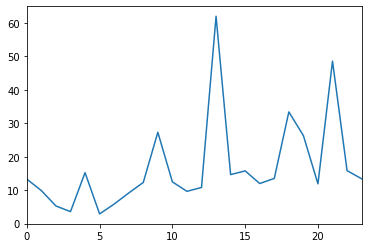

In [27]:
%matplotlib inline
taxi_df.groupby('hour').fare_amount.mean().compute().to_pandas().sort_index().plot()

In [28]:
# %%time
X_train = taxi_df.query('day < 25').persist()

# create a Y_train ddf with just the target variable
Y_train = X_train[['fare_amount']].persist()
# drop the target variable from the training ddf
X_train = X_train[X_train.columns.difference(['fare_amount'])]

# this wont return until all data is in GPU memory
done = wait([X_train, Y_train])

In [30]:
len(X_train)

110571695

In [31]:
%%time
import dask_xgboost as dxgb_gpu

params = {
    'learning_rate': 0.3,
    'max_depth': 8,
    'objective': 'reg:squarederror',
    'subsample': 0.6,
    'gamma': 1,
    'silent': True,
    'verbose_eval': True,
    'tree_method':'gpu_hist',
    'n_gpus': 1
}

trained_model = dxgb_gpu.train(client, headnode, params, X_train, Y_train, num_boost_round=10)
    

CPU times: user 72 ms, sys: 24 ms, total: 96 ms
Wall time: 14.1 s


## How good is our model

In [32]:
def drop_empty_partitions(df):
    lengths = df.map_partitions(len).compute()
    nonempty = [length > 0 for length in lengths]
    return df.partitions[nonempty]

In [33]:
X_test = taxi_df.query('day >= 25').persist()
X_test = drop_empty_partitions(X_test)

# Create Y_test with just the fare amount
Y_test = X_test[['fare_amount']]

# Drop the fare amount from X_test
X_test = X_test[X_test.columns.difference(['fare_amount'])]

# display test set size
len(X_test)

27795923

In [34]:
Y_test['prediction'] = dxgb_gpu.predict(client, trained_model, X_test)

ValueError: Metadata inference failed in `_predict_part`.

You have supplied a custom function and Dask is unable to 
determine the type of output that that function returns. 

To resolve this please provide a meta= keyword.
The docstring of the Dask function you ran should have more information.

Original error is below:
------------------------
TypeError('can not initialize DMatrix from DataFrame')

Traceback:
---------
  File "/home/nfs/jtomlinson/miniconda3/envs/kdd-demo/lib/python3.7/site-packages/dask/dataframe/utils.py", line 170, in raise_on_meta_error
    yield
  File "/home/nfs/jtomlinson/miniconda3/envs/kdd-demo/lib/python3.7/site-packages/dask/dataframe/core.py", line 4714, in _emulate
    return func(*_extract_meta(args, True), **_extract_meta(kwargs, True))
  File "/home/nfs/jtomlinson/Projects/dask/dask-xgboost/dask_xgboost/core.py", line 196, in _predict_part
    dm = xgb.DMatrix(part)
  File "/home/nfs/jtomlinson/miniconda3/envs/kdd-demo/lib/python3.7/site-packages/xgboost/core.py", line 413, in __init__
    ' {}'.format(type(data).__name__))


## Clean up Dask cluster

In [35]:
run.cancel()

## Delete AzureML cluster

In [ ]:
gpu_cluster.delete()
try:
    gpu_cluster.wait_for_completion(show_output=True)
except ComputeTargetException:
    print('Deleted')

Deleting

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/nfs/jtomlinson/miniconda3/envs/kdd-demo/lib/python3.7/site-packages/distributed/utils.py", line 656, in log_errors
    yield
  File "/home/nfs/jtomlinson/miniconda3/envs/kdd-demo/lib/python3.7/site-packages/distributed/client.py", line 1267, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/nfs/jtomlinson/miniconda3/envs/kdd-demo/lib/python3.7/site-packages/distributed/utils.py", line 656, in log_errors
    yield
  File "/home/nfs/jtomlinson/miniconda3/envs/kdd-demo/lib/python3.7/site-packages/distributed/client.py", line 997, in _reconnect
    await self._close()
  File "/home/nfs/jtomlinson/miniconda3/envs/kdd-demo/lib/python3.7/site-packages/distributed/client.py", li